# Compare downstream of fine-tuned model vs direct transfer of BrainLM on development dataset

The development dataset and the prediction workflow is adopted from MAIN educational workshop on Nilearn.

This dataset is an easy target as there's a known bias: the coverage of the brain scan betwenn kids and adults are different in the cerebellum.
When using an atlas that covers the cerebellum to extract features, the classification task should easily overfit.

Since BrainLM uses an atlas that covers cerebellum, this is a good dataset to test if the features got through direct transfer is anything useful.



The BrainLM model used: 650M and 111M.

Data preperation: giga-connectome, robust scaler normalisation.
Fine tune behaviour of data from the normalisation workflow shipped with BrainLM performs badly (R^2=0.0), hence it's not included in this comparison.

Prediction pipeline:
- Standard scalar on the feature
- PCA (5 components) on the standardised features
- Stratified 4 fold cross valiation
- Binary prediction with SVM (C=1, class_weight='balanced')


## Results

|Feature	| Time series | Functional connectivity | CLS token - attention head	| CLS token - embedding	| CLS token - attention head	| CLS token - embedding |CLS token - attention head	| CLS token - embedding	| CLS token - attention head	| CLS token - embedding |
|----|----|----|----|----|----|----|----|----|----|----|
| Model	| N/A | N/A | 650M	| 650M	| 650M	| 650M | 111M	| 111M	| 111M	| 111M |
| Fine-tune?	| N/A | N/A | N	| N	| Y	| Y | N	| N	| Y	| Y |
|Adult F1 score	| 0.4 |	0.85 |	0.36 |	0.53 |	0.33 |	0.67 | 0.33 | 0.56 | 0.34 | 0.54|
|Child F1 score	| 0.81 |	0.96 |	0.61 |	0.83 |	0.48 |	0.89 | 0.20 | 0.84 | 0.24 | 0.84|
|Overall accuracy |	0.71 |	0.94 |	0.52 |	0.75 |	0.41 |	0.84 | 0.27 | 0.77 | 0.29 | 0.76|

## Conclusions

- Features from BraimLM under perfrom comparing to functional connectivity, but better than  straight time series
- 650 M performs better than 111 M
- The CLS token from attension heads are all performing bad

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from datasets import load_from_disk
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

## Loading data

When creating baseline with the preprocessed recording.

For this task, functional connectivity is know to be the feature that can easily over fit.

For the baseline I will use functional connectivity and time series of the raw data.


In [2]:
# load data
features_direct = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_650M/direct_transfer.arrow")
features_finetune = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_650M/finetuning_transfer.arrow")

ts_flatten = [np.array(example).reshape(3, 424, 160)[0].T.flatten() for example in features_direct['padded_recording']]

correlation_baseline = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features_direct['padded_recording']]
fc_baseline = correlation_baseline.fit_transform(ts)

In [3]:
def pca_svc(C, x, y, title):
    """
    Extract the top 5 principal components and use a SVM to predict categorical
    label, 3 fold CV.
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=5)), 
        ('svc', SVC(C=C, class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
    scores = cross_val_score(pipe, x, y, cv=cv)
    y_pred = cross_val_predict(pipe, x, y, cv=cv)

    overall_acc = accuracy_score(y_pred=y_pred, y_true=y)
    overall_cr = classification_report(y_pred=y_pred, y_true=y)
    overall_cm = confusion_matrix(y_pred=y_pred, y_true=y)
    print('Overall Accuracy:', overall_acc)
    print(overall_cr)

    thresh = overall_cm.max() / 2
    cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
    plt.figure(figsize=(5, 4))
    plt.title(title)
    sns.heatmap(cmdf, cmap='copper', annot=cmdf, vmax=thresh, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Observed')


In [4]:
def plot_pca(feature, feature_name):
    """Plot PCA of the given feature."""
    ss = StandardScaler().fit(feature)
    feature = ss.transform(feature)
    pca = PCA(n_components=100)
    pca.fit(feature)
    feat_pca = pca.transform(feature)
    # plot pc as heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(feat_pca, cmap='viridis', cbar=True)
    plt.title(f'PCA of {feature_name}')
    plt.xlabel('Principal Components')
    plt.ylabel('Samples')
    plt.show()

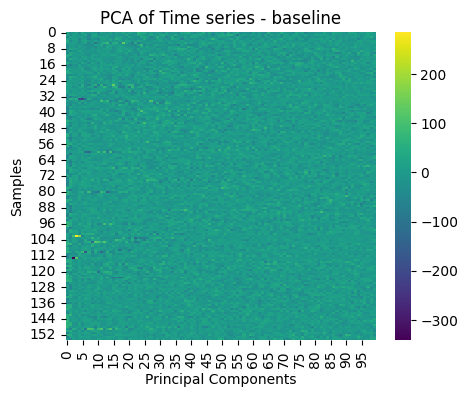

Overall Accuracy: 0.7096774193548387
              precision    recall  f1-score   support

       adult       0.36      0.45      0.40        33
       child       0.84      0.78      0.81       122

    accuracy                           0.71       155
   macro avg       0.60      0.62      0.60       155
weighted avg       0.74      0.71      0.72       155



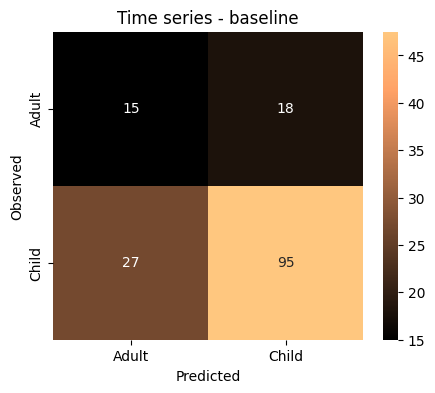

In [5]:
plot_pca(ts_flatten, "Time series - baseline")

pca_svc(C=1, x=ts_flatten, y=np.array(features_direct['Child_Adult']), title="Time series - baseline")

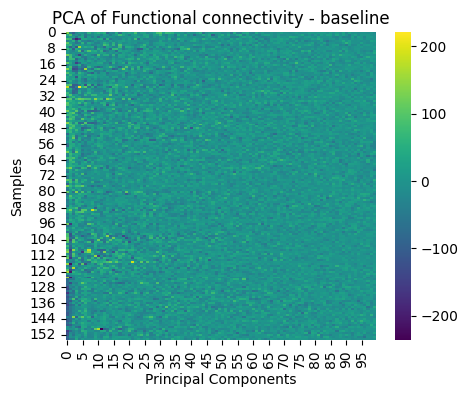

Overall Accuracy: 0.9354838709677419
              precision    recall  f1-score   support

       adult       0.85      0.85      0.85        33
       child       0.96      0.96      0.96       122

    accuracy                           0.94       155
   macro avg       0.90      0.90      0.90       155
weighted avg       0.94      0.94      0.94       155



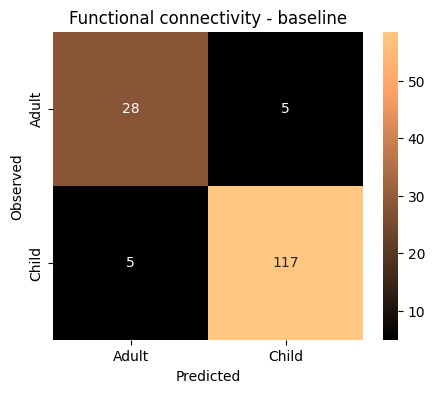

In [6]:
plot_pca(fc_baseline, "Functional connectivity - baseline")
pca_svc(C=1, x=fc_baseline, y=np.array(features_direct['Child_Adult']), title="Functional connectivity - baseline")


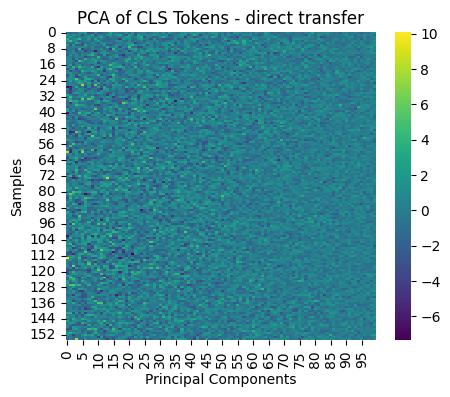

Overall Accuracy: 0.5161290322580645
              precision    recall  f1-score   support

       adult       0.25      0.64      0.36        33
       child       0.83      0.48      0.61       122

    accuracy                           0.52       155
   macro avg       0.54      0.56      0.49       155
weighted avg       0.71      0.52      0.56       155



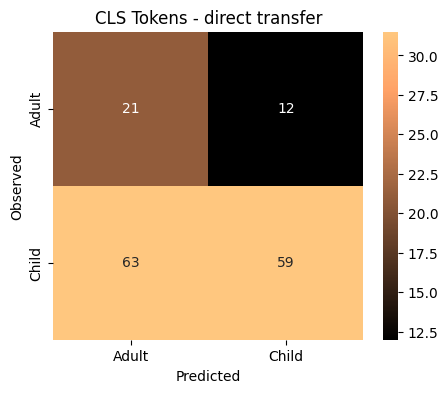

In [7]:
plot_pca(np.array(features_direct['cls_token']).squeeze(), "CLS Tokens - direct transfer")
pca_svc(C=1, x=np.array(features_direct['cls_token']).squeeze(), y=np.array(features_direct['Child_Adult']), title="CLS Tokens - direct transfer")

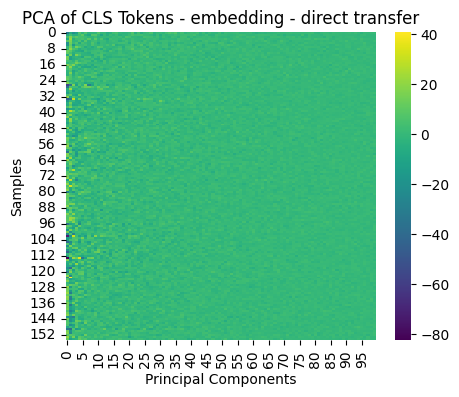

Overall Accuracy: 0.7483870967741936
              precision    recall  f1-score   support

       adult       0.44      0.67      0.53        33
       child       0.90      0.77      0.83       122

    accuracy                           0.75       155
   macro avg       0.67      0.72      0.68       155
weighted avg       0.80      0.75      0.76       155



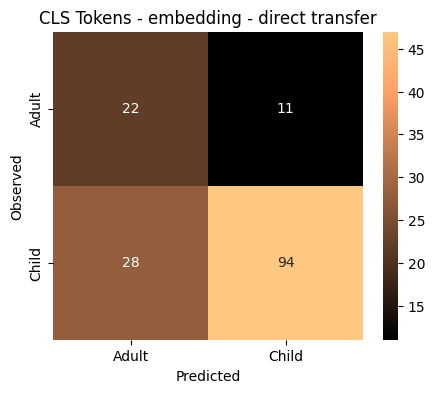

In [8]:
plot_pca(np.array(features_direct['cls_embedding']).squeeze(), "CLS Tokens - embedding - direct transfer")
pca_svc(C=1, x=np.array(features_direct['cls_embedding']).squeeze(), y=np.array(features_direct['Child_Adult']), title="CLS Tokens - embedding - direct transfer")

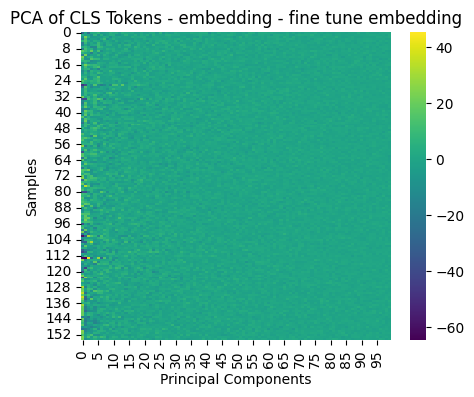

Overall Accuracy: 0.8387096774193549
              precision    recall  f1-score   support

       adult       0.60      0.76      0.67        33
       child       0.93      0.86      0.89       122

    accuracy                           0.84       155
   macro avg       0.76      0.81      0.78       155
weighted avg       0.86      0.84      0.85       155



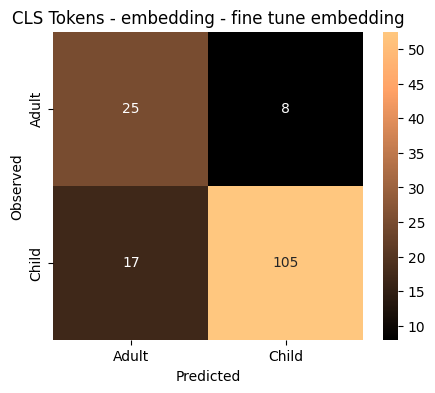

In [9]:
plot_pca(np.array(features_finetune['cls_embedding']).squeeze(), "CLS Tokens - embedding - fine tune embedding")
pca_svc(C=1, x=np.array(features_finetune['cls_embedding']).squeeze(), y=np.array(features_finetune['Child_Adult']), title="CLS Tokens - embedding - fine tune embedding")

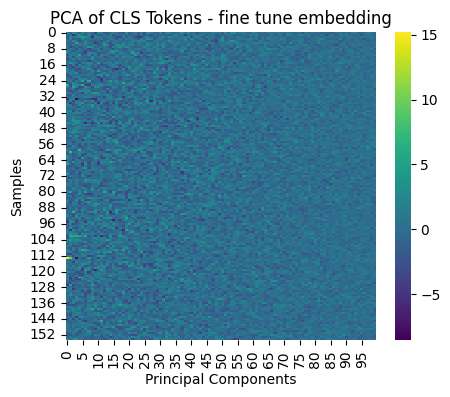

Overall Accuracy: 0.4129032258064516
              precision    recall  f1-score   support

       adult       0.22      0.67      0.33        33
       child       0.79      0.34      0.48       122

    accuracy                           0.41       155
   macro avg       0.50      0.51      0.40       155
weighted avg       0.67      0.41      0.45       155



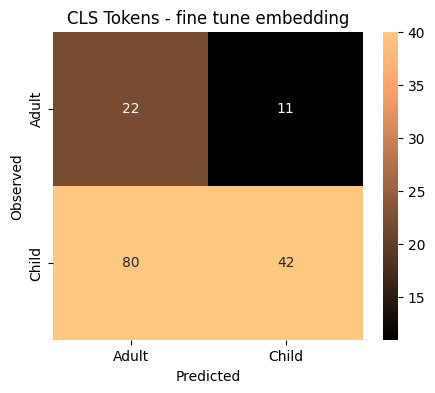

In [10]:
plot_pca(np.array(features_finetune['cls_token']).squeeze(), "CLS Tokens - fine tune embedding")
pca_svc(C=1, x=np.array(features_finetune['cls_token']).squeeze(), y=np.array(features_finetune['Child_Adult']), title="CLS Tokens - fine tune embedding")

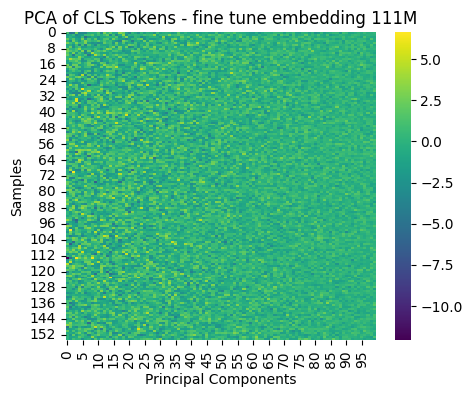

Overall Accuracy: 0.2903225806451613
              precision    recall  f1-score   support

       adult       0.21      0.85      0.34        33
       child       0.77      0.14      0.24       122

    accuracy                           0.29       155
   macro avg       0.49      0.49      0.29       155
weighted avg       0.65      0.29      0.26       155



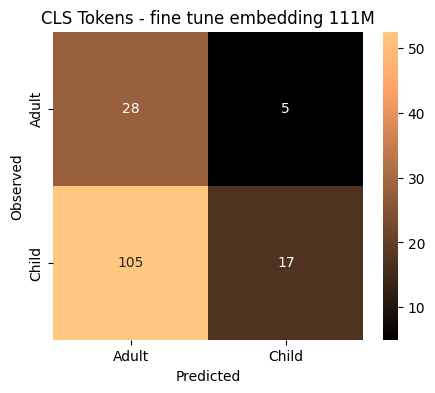

In [11]:
features_finetune = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_111M/finetuning_transfer.arrow")
plot_pca(np.array(features_finetune['cls_token']).squeeze(), "CLS Tokens - fine tune embedding 111M")
pca_svc(C=1, x=np.array(features_finetune['cls_token']).squeeze(), y=np.array(features_finetune['Child_Adult']), title="CLS Tokens - fine tune embedding 111M")

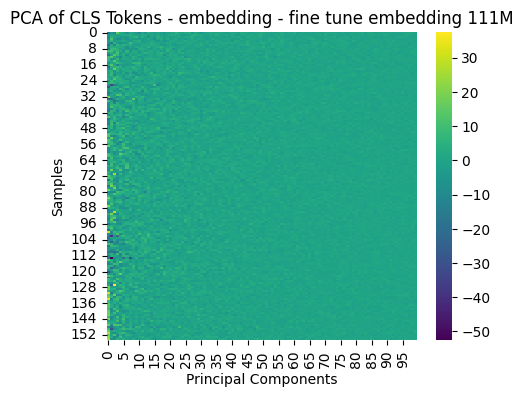

Overall Accuracy: 0.7612903225806451
              precision    recall  f1-score   support

       adult       0.46      0.67      0.54        33
       child       0.90      0.79      0.84       122

    accuracy                           0.76       155
   macro avg       0.68      0.73      0.69       155
weighted avg       0.80      0.76      0.78       155



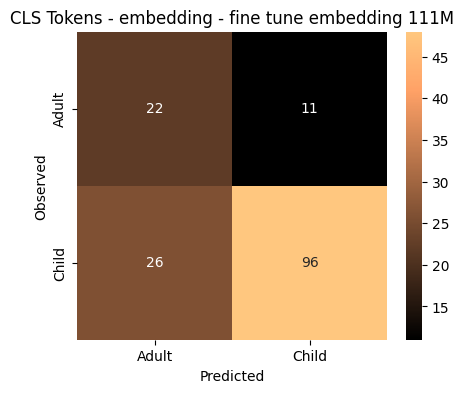

In [12]:
plot_pca(np.array(features_finetune['cls_embedding']).squeeze(), "CLS Tokens - embedding - fine tune embedding 111M")
pca_svc(C=1, x=np.array(features_finetune['cls_embedding']).squeeze(), y=np.array(features_finetune['Child_Adult']), title="CLS Tokens - embedding - fine tune embedding 111M")

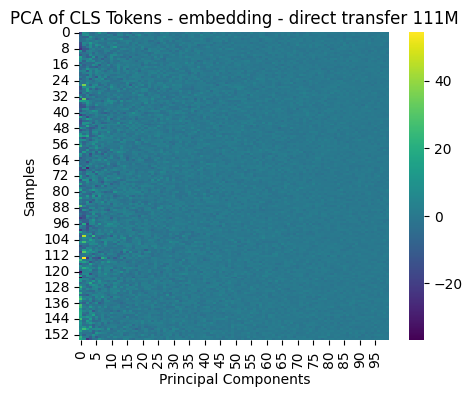

Overall Accuracy: 0.7677419354838709
              precision    recall  f1-score   support

       adult       0.47      0.70      0.56        33
       child       0.91      0.79      0.84       122

    accuracy                           0.77       155
   macro avg       0.69      0.74      0.70       155
weighted avg       0.81      0.77      0.78       155



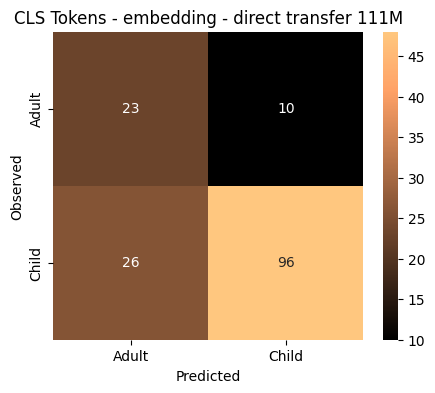

In [13]:
features_direct = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_111M/direct_transfer.arrow")

plot_pca(np.array(features_direct['cls_embedding']).squeeze(), "CLS Tokens - embedding - direct transfer 111M")
pca_svc(C=1, x=np.array(features_direct['cls_embedding']).squeeze(), y=np.array(features_direct['Child_Adult']), title="CLS Tokens - embedding - direct transfer 111M")


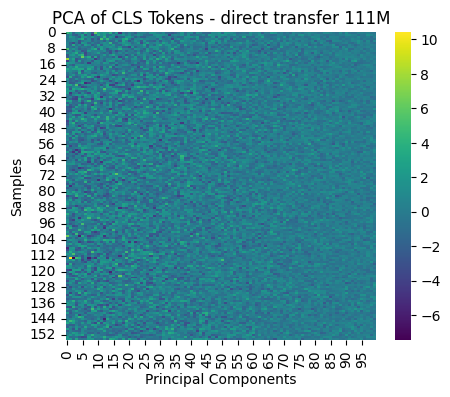

Overall Accuracy: 0.2709677419354839
              precision    recall  f1-score   support

       adult       0.21      0.85      0.33        33
       child       0.74      0.11      0.20       122

    accuracy                           0.27       155
   macro avg       0.47      0.48      0.26       155
weighted avg       0.62      0.27      0.23       155



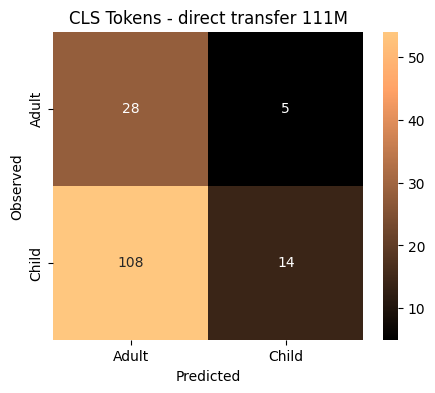

In [14]:

plot_pca(np.array(features_direct['cls_token']).squeeze(), "CLS Tokens - direct transfer 111M")
pca_svc(C=1, x=np.array(features_direct['cls_token']).squeeze(), y=np.array(features_direct['Child_Adult']), title="CLS Tokens - direct transfer 111M")